In [2]:
import pandas as pd

In [8]:
chunksize = 5_000_000
file_path = "rba-dataset/rba-dataset.csv"

training_df = pd.DataFrame()
test_df = pd.DataFrame()

# Processa o CSV em chunks
for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
    if i < 3:  # Primeiros 3 chunks vão para o dataframe de treinamento
        training_df = pd.concat([training_df, chunk], ignore_index=True)
    elif i == 3:  # O último chunk vai para o dataframe de teste
        test_df = chunk.head(1_000_000)
        break

print(f"Training DataFrame: {len(training_df)} linhas")
print(f"Test DataFrame: {len(test_df)} linhas")


Training DataFrame: 15000000 linhas
Test DataFrame: 1000000 linhas


# Pré-Processamento

In [9]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(df):
    """Função para alterar as colunas categóricas para numéricas"""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    le = LabelEncoder()

    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    return df

In [10]:
# separa test_df em eval e test
eval_df = test_df.iloc[:500_000]
test_df = test_df.iloc[500_000:]

# remove as 3 colunas de label
train_df = training_df.iloc[:, :-3]
test_df = test_df.iloc[:, :-3]

# remove colunas desnecessárias
train_df = train_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
test_df = test_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
eval_df = eval_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])

In [11]:
# transforma as colunas categóricas em numéricas
train_df = encode_categorical_columns(train_df)
test_df = encode_categorical_columns(test_df)
eval_df = encode_categorical_columns(eval_df)

# Treinamento

## Isolation Forest v2

Esse modelo não difere em nada em relação ao baseline exceto pela quantidade de dados treinados. Assim, pode ser considerado uma baseline alternativa.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = IsolationForest(n_estimators=1000, contamination='auto')
model.fit(train_df)

In [ ]:
# Avalia o modelo
y_pred = model.predict(eval_df.iloc[:, :-3])
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_true = [1 if x == True else 0 for x in eval_df['Login Successful']]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

array([-1, -1, -1, ..., -1, -1, -1], shape=(500000,))

In [26]:
anomaly_scores = model.decision_function(eval_df.iloc[:, :-3])
print(set(anomaly_scores))

{np.float64(-0.053464555139726144), np.float64(-0.02767834343467257), np.float64(-0.045348296023803414), np.float64(-0.056824120299552305), np.float64(-0.059201787663596406), np.float64(-0.04643663201932213), np.float64(-0.04190163433486305), np.float64(-0.0703562944006535), np.float64(-0.05537090108146003), np.float64(-0.07189270389653757), np.float64(-0.020115216917474754), np.float64(-0.060804620138600884), np.float64(-0.04624839500401723), np.float64(-0.10229264540411243), np.float64(-0.08185974286123676), np.float64(-0.06049089901032134), np.float64(-0.04400871906306425), np.float64(-0.04262124811554391), np.float64(-0.06234739223715302), np.float64(-0.0577615496432875), np.float64(-0.1155602776489556), np.float64(-0.06355158318915499), np.float64(-0.09880623436042668), np.float64(-0.06020036871636847), np.float64(-0.12516710390311503), np.float64(-0.05133532675656327), np.float64(-0.05691560296456022), np.float64(-0.03742347014978453), np.float64(-0.031907839298051965), np.float6

In [32]:
print(anomaly_scores.mean())
print(anomaly_scores.std())
print("Mean + 2std: ", anomaly_scores.mean() + 2 * anomaly_scores.std())
threshold = anomaly_scores.mean() + 2 * anomaly_scores.std()

-0.05882507669724507
0.02002017236591309
Mean + 2std:  -0.01878473196541889


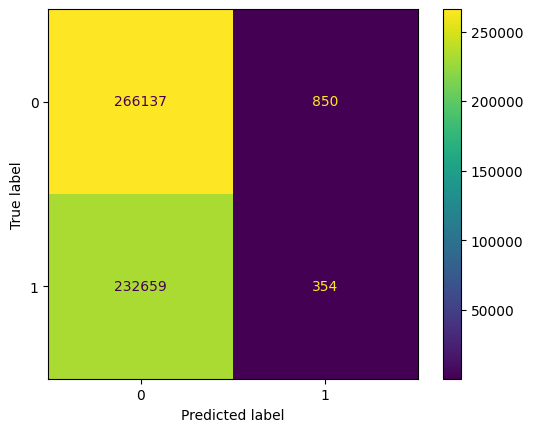

In [33]:
y_pred = [1 if x > threshold else 0 for x in anomaly_scores]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 1000,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Isolation Forest v3
Fazemos uma breve análise dos parâmetros dos estimadores do modelo anterior e rodamos um novo modelo com alguns parâmetros alterados, por fim de experimentação.